In [ ]:
# !pip install seaborn pandas numpy matplotlib
# !pip install plotly
%matplotlib inline

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

Look into the details about selected features using a reference taxonomy file

In [ ]:
# read the reference data obtained from Green Genes
reference_data = pd.read_csv("97_otu_taxonomy.txt", sep="\t", header=None)
reference_data.columns = ["OTU ID", "Taxonomy"]

# split the taxonomy into the different levels
reference_data["Kingdom"] = reference_data["Taxonomy"].apply(lambda x: x.split("; ")[0])
reference_data["Phylum"] = reference_data["Taxonomy"].apply(lambda x: x.split("; ")[1])
reference_data["Class"] = reference_data["Taxonomy"].apply(lambda x: x.split("; ")[2])
reference_data["Order"] = reference_data["Taxonomy"].apply(lambda x: x.split("; ")[3])
reference_data["Family"] = reference_data["Taxonomy"].apply(lambda x: x.split("; ")[4])
reference_data["Genus"] = reference_data["Taxonomy"].apply(lambda x: x.split("; ")[5])
reference_data["Species"] = reference_data["Taxonomy"].apply(lambda x: x.split("; ")[6])

# remove the taxonomy column
reference_data = reference_data.drop("Taxonomy", axis=1)
# reference data is now a dataframe with the OTU ID and the different taxonomy levels
print(reference_data.head())


# read the selected attributes
selected_filename = "best_first_wrapper_turkey.csv"
selected_attributes = pd.read_csv(selected_filename)
# get a list of the selected attributes in the "Name" column
selected_attributes = selected_attributes["Name"][:-1].tolist()


# read the data
data_filename = "normalized_feature_table_three_class.csv"
data = pd.read_csv(data_filename)

In [ ]:
taxonomic_levels = {}
for attribute in selected_attributes:
    taxonomic_levels[attribute] = []
    for column in reference_data.columns[1:]:
        # get the taxonomic level
        taxonomic_level = reference_data.loc[reference_data["OTU ID"] == int(attribute)][column].values[0]
        # print(attribute, taxonomic_level)
        taxonomic_levels[attribute].append(taxonomic_level)

        
# convert the dictionary to a dataframe
taxonomic_levels_df = pd.DataFrame(taxonomic_levels).T
taxonomic_levels_df.columns = reference_data.columns[1:]
print(taxonomic_levels_df.head())

# save the selected attributes with the taxonomic levels
taxonomic_levels_df.to_csv("taxonomic_levels.csv")

**Perform Statistical Analysis**

In [ ]:
# get the data of the selected attributes
selected_data = data.loc[:, selected_attributes]
selected_data["class"] = data["class"]
print(selected_data.head())


In [ ]:
# Separate features and target
features = selected_data.drop(columns=['class'])
target = selected_data['class']

# Step 1: Statistical Analysis
summary_stats = features.groupby(target).agg(['mean', 'std'])
print("Summary Statistics:\n", summary_stats)

# Perform ANOVA to identify significant features
anova_results = {}
for column in features.columns:
    groups = [features[column][target == cls] for cls in target.unique()]
    anova_results[column] = f_oneway(*groups)

# Convert ANOVA results to a DataFrame
anova_df = pd.DataFrame({
    'Feature': anova_results.keys(),
    'F-statistic': [res.statistic for res in anova_results.values()],
    'p-value': [res.pvalue for res in anova_results.values()]
}).sort_values(by='p-value')

print("\nANOVA Results (sorted by p-value):\n", anova_df)


Significant Features (p-value < 0.05):
    Feature  F-statistic       p-value
3   191703    19.016374  6.474539e-08
6   327383     9.093419  2.083570e-04
9  1076818     7.267241  1.042717e-03


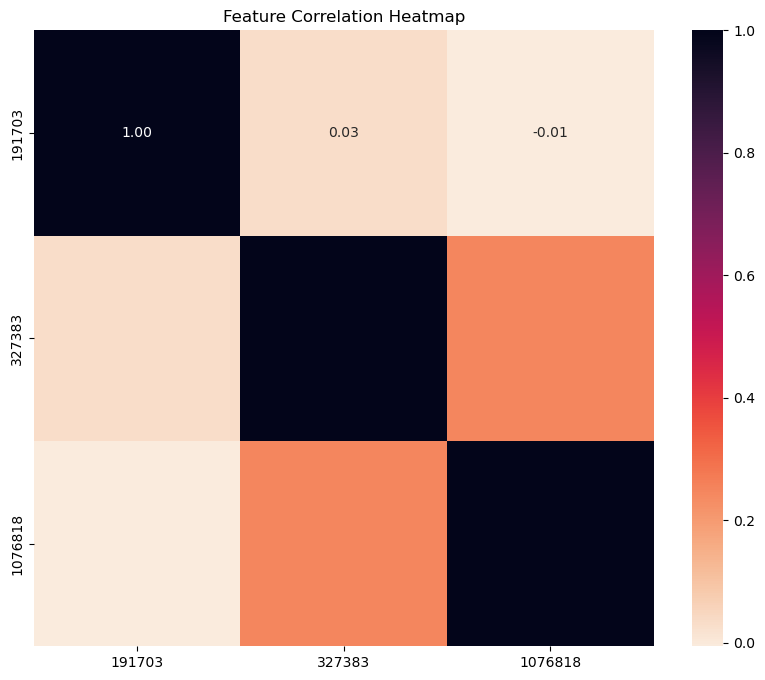

In [ ]:
p_value_threshold = 0.05
significant_features = anova_df[anova_df['p-value'] < p_value_threshold]
print("\nSignificant Features (p-value < 0.05):\n", significant_features)


selected_features = features[significant_features['Feature']]
plt.figure(figsize=(10, 8))
corr_matrix = selected_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='rocket_r', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


Visualization to investigate the data further

In [38]:
def clean_taxonomic_level(attribute):
    # only keep taxonomic levels >3
    taxonomic_list = taxonomic_levels[attribute]
    taxonomic_list = [level for level in taxonomic_list if len(level) > 3]
    # remove the prefix
    taxonomic_list = [level.split("__")[1] for level in taxonomic_list]
    print(attribute, taxonomic_list)
    return taxonomic_list[-1]
    

In [39]:
import pandas as pd
import plotly.express as px

data_3d = data[significant_features['Feature'].values[:3]]
data_3d['class'] = data['class']  

x_label = clean_taxonomic_level(significant_features["Feature"].values[0])
y_label = clean_taxonomic_level(significant_features["Feature"].values[1])
z_label = clean_taxonomic_level(significant_features["Feature"].values[2])


fig = px.scatter_3d(
    data_3d,
    x=significant_features["Feature"].values[0],
    y=significant_features["Feature"].values[1],
    z=significant_features["Feature"].values[2],
    color='class',  # Different colors for each class
    color_discrete_map={
        'control': 'yellow',
        'alzheimer': 'red',
        'mci': 'orange'
    },
    title='3D Visualization of Significant Features',
)

# Customize layout
fig.update_layout(
    scene=dict(
        xaxis_title=x_label,
        yaxis_title=y_label,
        zaxis_title=z_label,
    ),
    legend_title="Class",
    margin=dict(l=0, r=0, b=0, t=40),
)

# Display the plot
fig.show()


191703 ['Bacteria', 'Firmicutes', 'Clostridia', 'Clostridiales']
327383 ['Bacteria', 'Firmicutes', 'Clostridia', 'Clostridiales', 'Ruminococcaceae']
1076818 ['Bacteria', 'Firmicutes', 'Clostridia', 'Clostridiales', 'Lachnospiraceae']


/var/folders/yp/kkdytntx39q1m03lrfdnh19r0000gn/T/ipykernel_72030/2178614524.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

